In [1]:
# IMPORTS
import gerrychain
from gerrychain import Graph
from gerrychain.tree import recursive_tree_part
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# LOAD TEXAS DATA
tx = gpd.read_file("Downloads/TX_vtds/TX_vtds.shp")

In [3]:
# LOOK AT DIFFERENT COLUMNS
list(tx)

['CNTYVTD',
 'VTD',
 'WHITE',
 'OTHER',
 'HISPANIC',
 'TOTPOP',
 'VAP',
 'BLACK',
 'BLKHISP',
 'WVAP',
 'HISPVAP',
 'BHVAP',
 'BVAP',
 'OTHVAP',
 'COUNTY',
 'FIPS',
 'PRES12R',
 'PRES12D',
 'SEN12R',
 'SEN12D',
 'TOTVR12',
 'TOTTO12',
 'SEN14R',
 'SEN14D',
 'GOV14R',
 'GOV14D',
 'TOTVR14',
 'TOTTO14',
 'PRES16D',
 'PRES16R',
 'TOTVR16',
 'TOTTO16',
 'USCD',
 'SEND',
 'HD',
 'AREA',
 'PERIM',
 'geometry']

<AxesSubplot: >

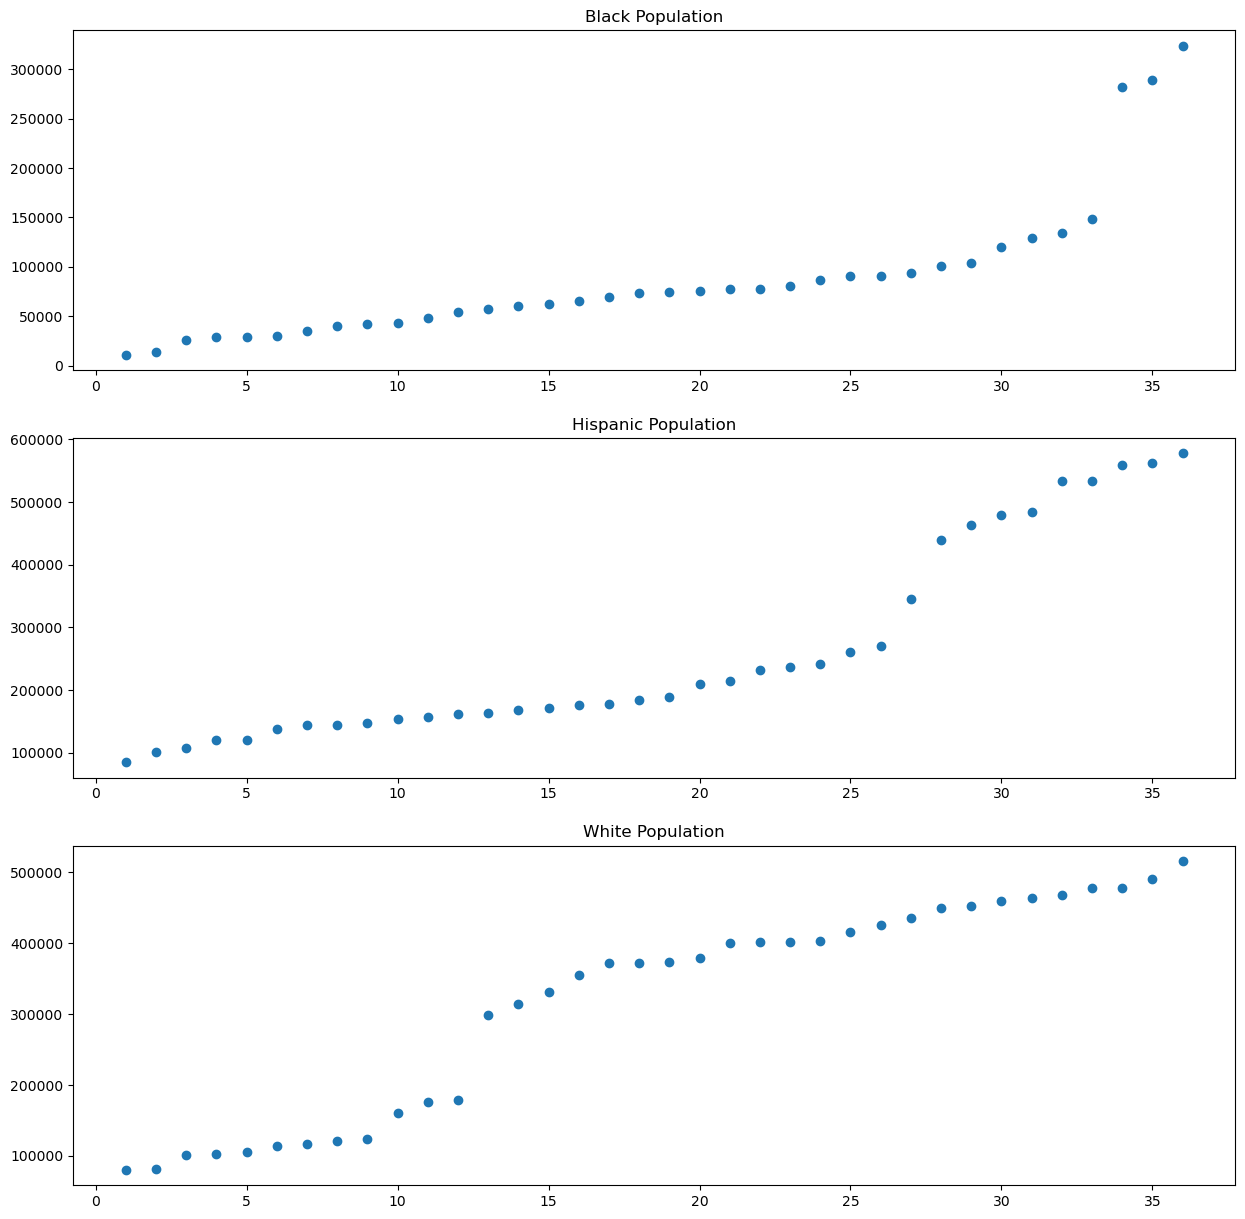

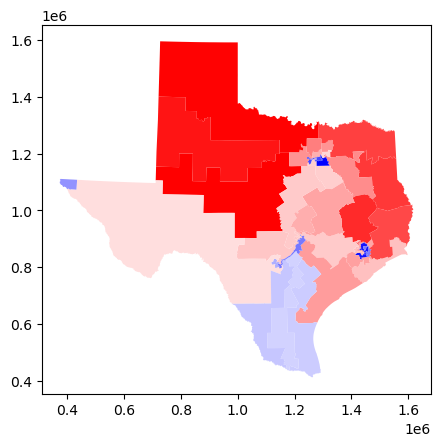

In [4]:
# LOOK AT DIFFERENT DIVISIONS
from matplotlib import pyplot as plt

county_graph = tx.dissolve(by="USCD", aggfunc="sum")

partisan_lean = []
for element_index in range(0, len(county_graph['GOV14R'])):
    partisan_lean.append(county_graph['GOV14R'][element_index]/(county_graph['GOV14R'][element_index] + county_graph['GOV14D'][element_index]))

fig, axs = plt.subplots(3, figsize=(15, 15))
# SCATTER PLOT FOR BLACK POPULATION
axs[0].scatter(x=range(1, 37), y=sorted(county_graph['BLACK']))
axs[0].title.set_text("Black Population")

# SCATTER PLOT FOR HISPANIC POPULATION
axs[1].scatter(x=range(1, 37), y=sorted(county_graph['HISPANIC']))
axs[1].title.set_text("Hispanic Population")

# SCATTER PLOT FOR WHITE POPULATION
axs[2].scatter(x=range(1, 37), y=sorted(county_graph['WHITE']))
axs[2].title.set_text("White Population")

# GEOPANDAS GRAPH FOR PARTISAN LEAN
county_graph['PARTISAN_LEAN']=partisan_lean
county_graph.plot(column='PARTISAN_LEAN', cmap='bwr')

In [17]:
print(list(county_graph["BLACK"]))

[129311.0, 73126.0, 65108.0, 80478.0, 104272.0, 134593.0, 86854.0, 62187.0, 281573.0, 77996.0, 29727.0, 60398.0, 42719.0, 148272.0, 14063.0, 28848.0, 101097.0, 289301.0, 48124.0, 40207.0, 28579.0, 93939.0, 25455.0, 77048.0, 57754.0, 54488.0, 42159.0, 35013.0, 74601.0, 323730.0, 90403.0, 91005.0, 120324.0, 11175.0, 75336.0, 69206.0]


In [5]:
# CREATE DUAL_GRAPH
dual_graph = Graph.from_file("Downloads/TX_vtds/TX_vtds.shp", ignore_errors=True)

In [6]:
# CREATE UPDATERS
from gerrychain import Partition
from gerrychain import Election
from gerrychain import updaters

# Boundary updater
my_updaters = {}
def number_of_cut_edges(partition):
    return len(partition["cut_edges"])
boundary_length_updater = {"number_cut_edges": number_of_cut_edges}
my_updaters.update(boundary_length_updater)

# Population updater
population_updater = {"population": updaters.Tally("TOTPOP", alias="population")}
my_updaters.update(population_updater)

# Election updater
election_updater = Election("PRES16", {"Democratic": "PRES16D", "Republican": "PRES16R"})

# Black population updater
black_population_updater = {"black_population" : updaters.Tally("BLACK", alias="black_population")}
my_updaters.update({election_updater.name : election_updater})
my_updaters.update(black_population_updater)

In [7]:
# BUILD PARTITION
from gerrychain import GeographicPartition
initial_partition = GeographicPartition(dual_graph, assignment="USCD", updaters=my_updaters)

In [8]:
# CREATE CONSTRAINTS
from gerrychain import constraints
population_constraint = constraints.within_percent_of_ideal_population(initial_partition, .05)
cut_edges_constraint = constraints.UpperBound(number_of_cut_edges, 5000)

In [9]:
# BUILD RECOM PROPOSAL
from functools import partial
from gerrychain.proposals import recom
ideal_population = sum(initial_partition["population"].values())
ideal_population = ideal_population / len(initial_partition)
tree_recom = partial(recom, pop_col = "TOTPOP", pop_target=ideal_population, epsilon=0.05, node_repeats=1)

In [33]:
# ACCEPTANCE FUNCTIONS
import random
def edge_accept(partition):
    if partition.parent["number_cut_edges"] > partition["number_cut_edges"]:
        bound = 0.01
    else:
        bound = 0.99
    return random.random() < bound


def pop_accept(partition):
    parent_counter = 0
    child_counter = 0
    for key in partition.parent["black_population"]:
        if partition.parent["black_population"][key] < 60000:
            parent_counter += 1
        if partition["black_population"][key] < 60000:
            child_counter += 1
    
    if child_counter < parent_counter:
        bound = 0.99
    else:
        bound = 0.01
    return random.random() < bound
    
def election_accept(partition):
    if partition["PRES16"].wins("Democratic"):
        bound = 0.99
    else:
        bound = 0.01
        
    return random.random() < bound
    
def pop_and_elect_accept(partition):
    if pop_accept(partition) and election_accept(partition):
        bound = 0.99
    elif pop_accept(partition) or election_accept(partition):
        bound = 0.5
    else:
        bound = 0.01
    return random.random() < bound
#     tx["NEW ASSIGNMENT"] = partition.assignment
#     county_graph = tx.dissolve(by="NEW ASSIGNMENT", aggfunc="sum")
#     black_pop = []
#     print(county_graph['BLACK'][0]/(county_graph['TOTPOP'][0]))
#     if county_graph['BLACK'][0]/(county_graph['TOTPOP'][0]) < 0.2:
#         bound = 0.01
#     else:
#         bound = 0.99
# #     for element_index in range(0, len(county_graph['BLACK'])):
# #         print(county_graph['BLACK'][element_index]/(county_graph['TOTPOP'][element_index]))
# #         if county_graph['BLACK'][element_index]/(county_graph['TOTPOP'][element_index]) < 0.15:
# #             bound = 0.01
# #             break
# #         else:
# #             bound = 0.99
#     return random.random() < bound

#     if partition.parent["BLACK"] > partition["BLACK"]:
#         bound = 0.01
#     else:
#         bound = 0.99
#     return random.random() < bound

In [34]:
# RUNNING MARKOV CHAIN
from gerrychain import MarkovChain
my_chain = MarkovChain(proposal=tree_recom, constraints=[population_constraint, cut_edges_constraint], accept=pop_and_elect_accept, initial_state = initial_partition, total_steps=1296)

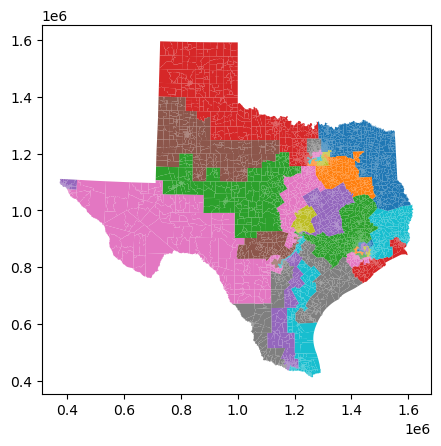

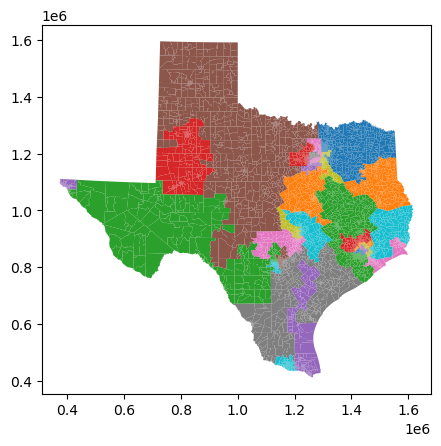

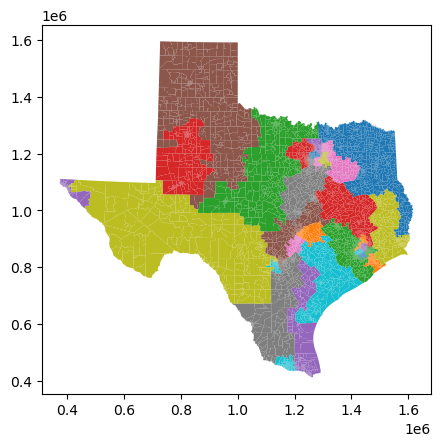

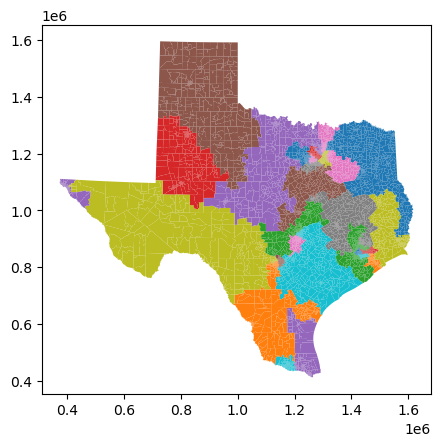

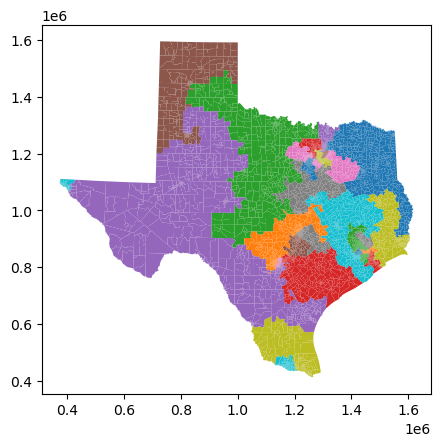

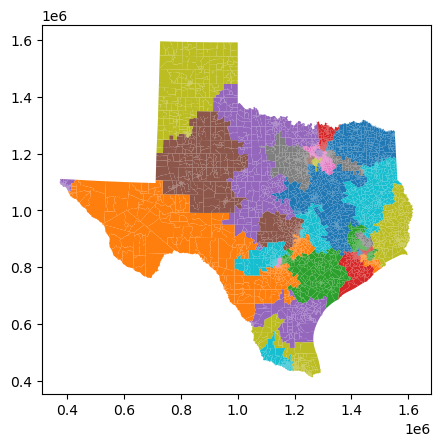

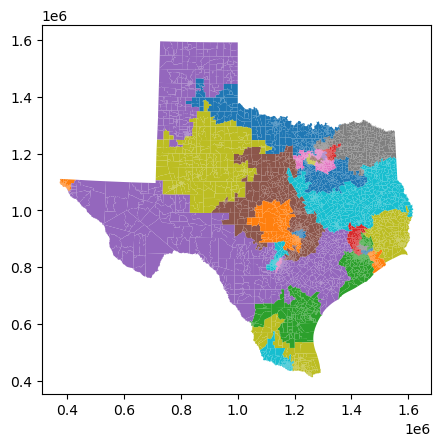

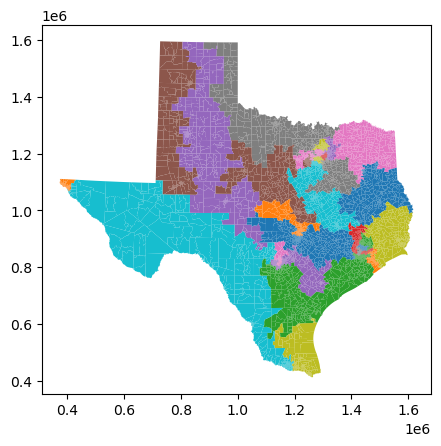

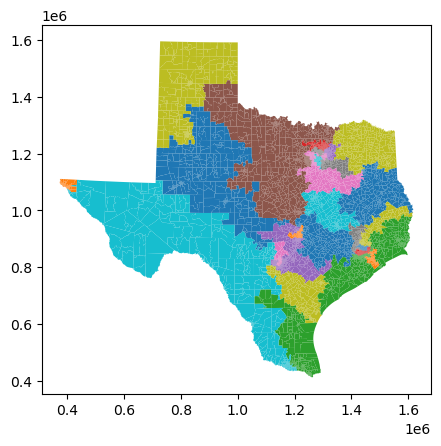

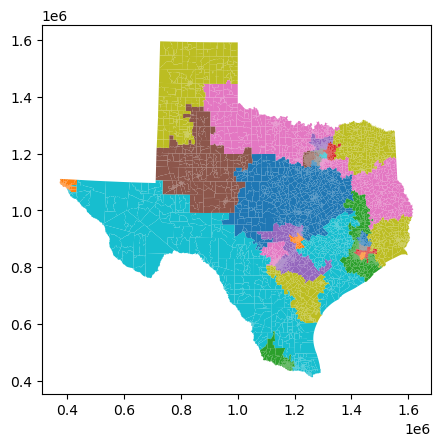

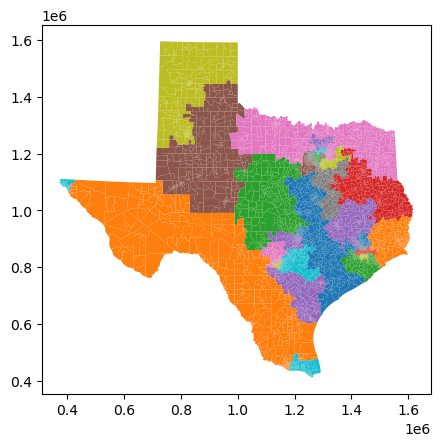

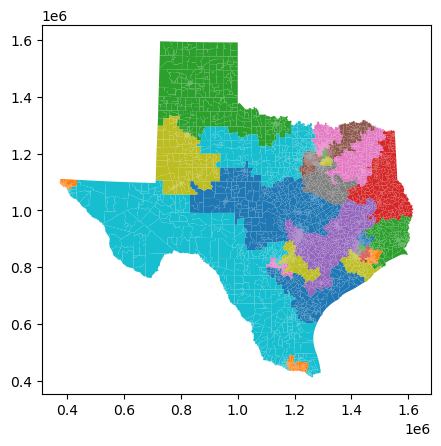

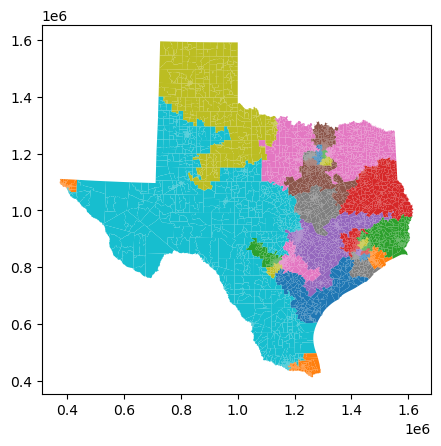

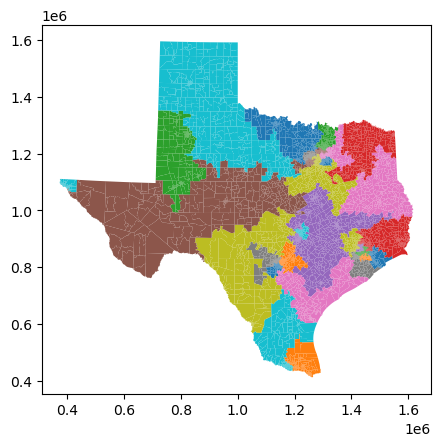

In [35]:
#print(initial_partition['number_cut_edges'])
def num_splits(partition, df=tx):
     df["current"] = df.index.map(partition.assignment)

for index, current_partition in enumerate(my_chain):
#     print("current partition: ", list(current_partition))
    if index == 0 or index%100 == 0 or index == 1295:
        tx["NEW ASSIGNMENT"] = current_partition.assignment
        tx.plot(column="NEW ASSIGNMENT")

<AxesSubplot: >

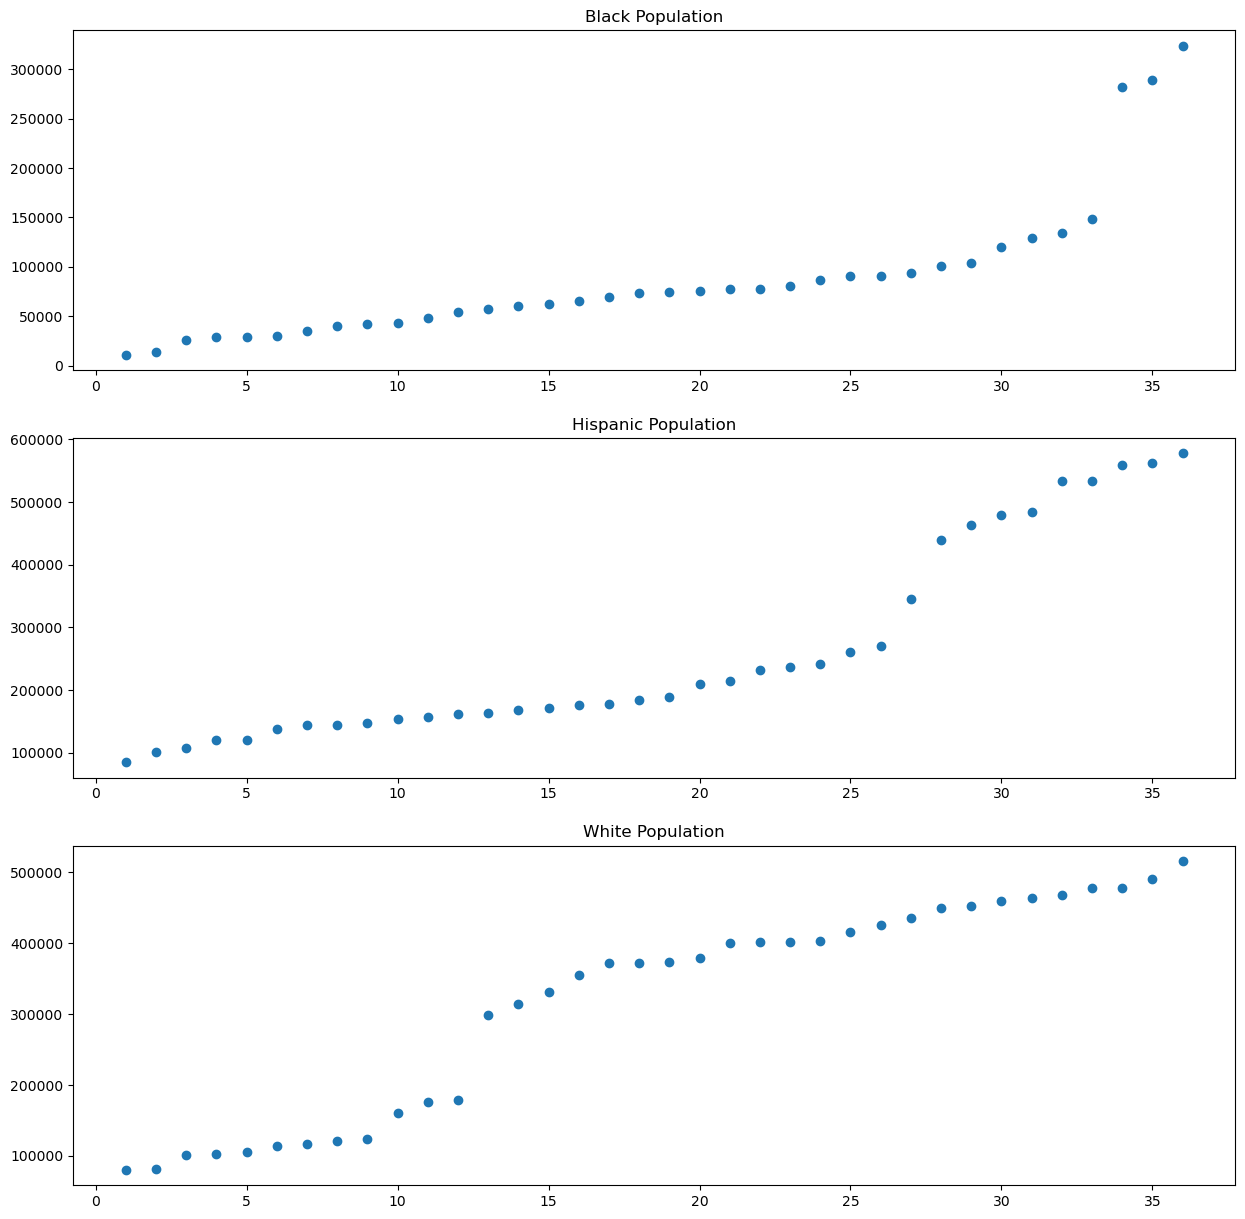

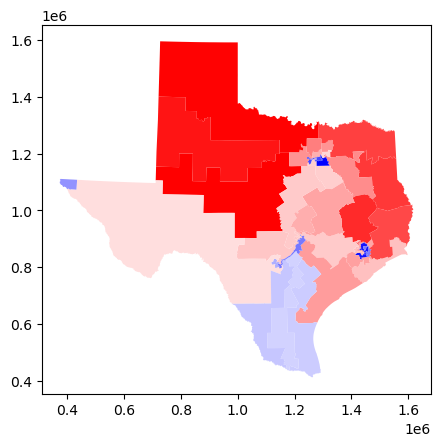

In [36]:
# LOOK AT DIFFERENT DIVISIONS
from matplotlib import pyplot as plt

county_graph = tx.dissolve(by="USCD", aggfunc="sum")

partisan_lean = []
for element_index in range(0, len(county_graph['GOV14R'])):
    partisan_lean.append(county_graph['GOV14R'][element_index]/(county_graph['GOV14R'][element_index] + county_graph['GOV14D'][element_index]))

fig, axs = plt.subplots(3, figsize=(15, 15))
# SCATTER PLOT FOR BLACK POPULATION
axs[0].scatter(x=range(1, 37), y=sorted(county_graph['BLACK']))
axs[0].title.set_text("Black Population")

# SCATTER PLOT FOR HISPANIC POPULATION
axs[1].scatter(x=range(1, 37), y=sorted(county_graph['HISPANIC']))
axs[1].title.set_text("Hispanic Population")

# SCATTER PLOT FOR WHITE POPULATION
axs[2].scatter(x=range(1, 37), y=sorted(county_graph['WHITE']))
axs[2].title.set_text("White Population")

# GEOPANDAS GRAPH FOR PARTISAN LEAN
county_graph['PARTISAN_LEAN']=partisan_lean
county_graph.plot(column='PARTISAN_LEAN', cmap='bwr')

<AxesSubplot: >

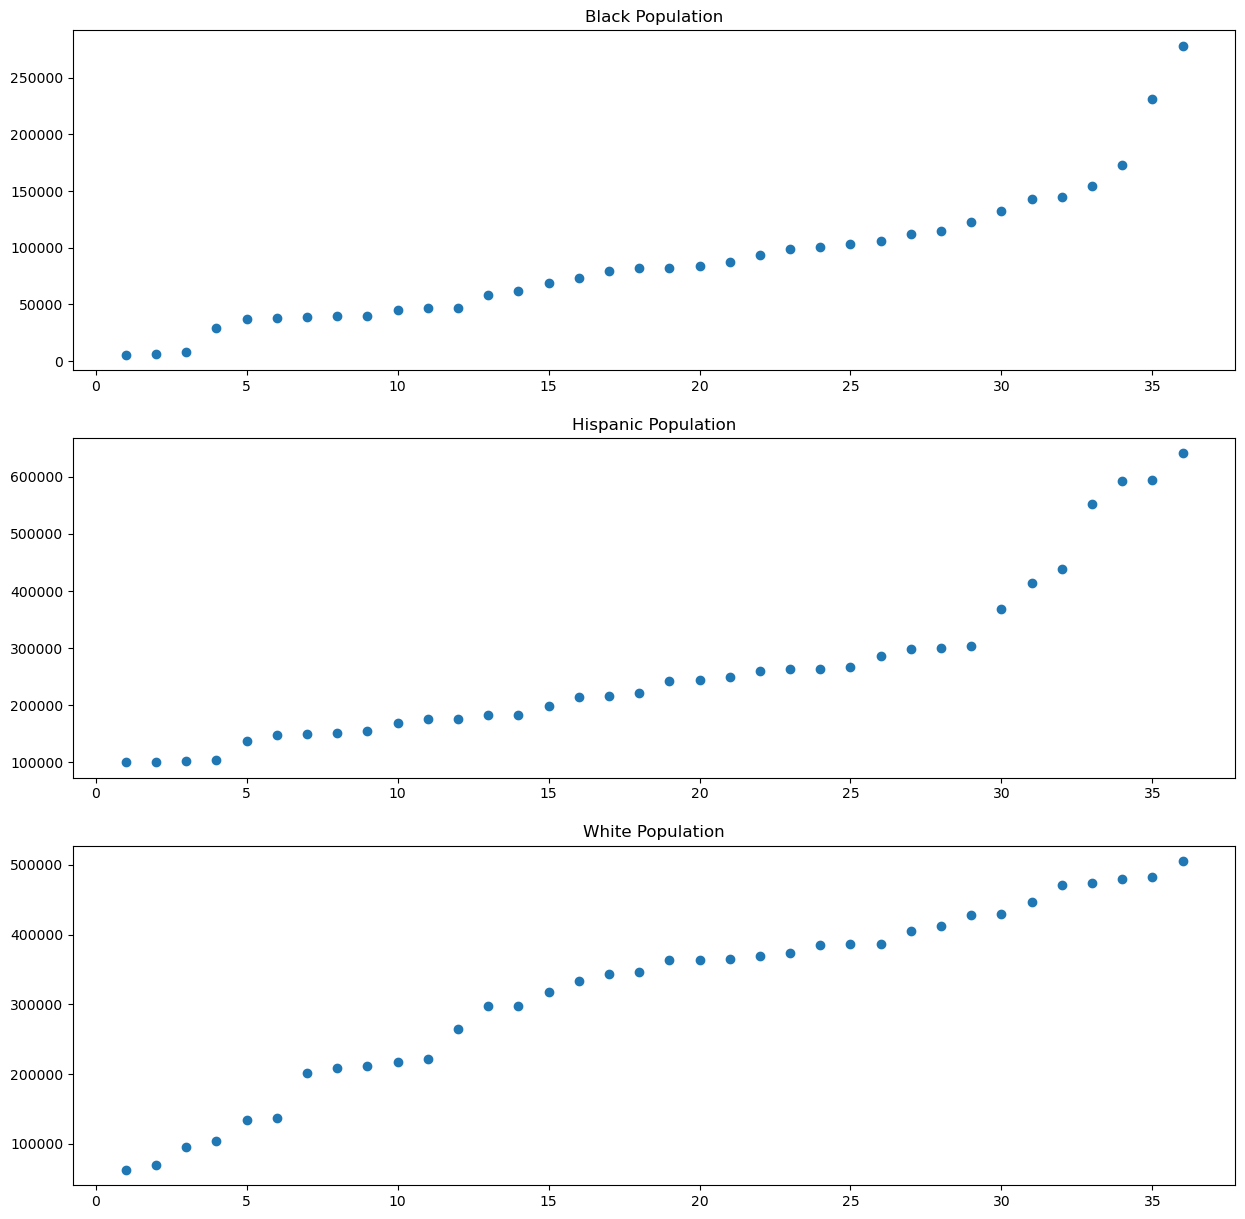

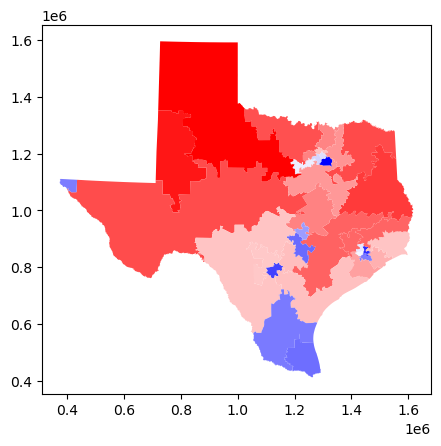

In [37]:
markov_graph = tx.dissolve(by="NEW ASSIGNMENT", aggfunc="sum")

partisan_lean = []
for element_index in range(0, len(markov_graph['GOV14R'])):
    partisan_lean.append(markov_graph['GOV14R'][element_index]/(markov_graph['GOV14R'][element_index] + markov_graph['GOV14D'][element_index]))

fig, axs = plt.subplots(3, figsize=(15, 15))
# SCATTER PLOT FOR BLACK POPULATION
axs[0].scatter(x=range(1, 37), y=sorted(markov_graph['BLACK']))
axs[0].title.set_text("Black Population")

# SCATTER PLOT FOR HISPANIC POPULATION
axs[1].scatter(x=range(1, 37), y=sorted(markov_graph['HISPANIC']))
axs[1].title.set_text("Hispanic Population")

# SCATTER PLOT FOR WHITE POPULATION
axs[2].scatter(x=range(1, 37), y=sorted(markov_graph['WHITE']))
axs[2].title.set_text("White Population")

# GEOPANDAS GRAPH FOR PARTISAN LEAN
markov_graph['PARTISAN_LEAN']=partisan_lean
markov_graph.plot(column='PARTISAN_LEAN', cmap='bwr')